# Hyperparameter Optimization with Optuna and Transformers

_Authored by: [Parag Ekbote](https://github.com/ParagEkbote)_

## **Problem:** 
Find the best hyperparameters to fine-tune a lightweight BERT model for text classification on a subset of the IMDB dataset.

## **Overview:**
This recipe demonstrates how to systematically optimize hyperparameters for transformer-based text classification models using automated search techniques. You'll learn to implement HPO using Optuna to find optimal learning rates and weight decay values for fine-tuning BERT on sentiment analysis tasks.

## **When to Use This Recipe:**

* You need to fine-tune pre-trained language models for classification tasks.

* Your model performance is plateauing and requires parameter refinement.

* You want to implement systematic, reproducible hyperparameter optimization.

### Notes

* For detailed guidance on hyperparameter search with Transformers, refer to the [Hugging Face HPO documentation](https://huggingface.co/docs/transformers/en/hpo_train).

In [ ]:
!pip install -q datasets evaluate transformers optuna wandb scikit-learn nbformat matplotlib

## Prepare Dataset and Set Model

Before you can train and evaluate a sentiment analysis model, you’ll need to prep the dataset. This section ensures that your data is structured and your model is primed for learning from scratch or fine-tuning in the case of BERT.


### 1. **Load the IMDB Dataset**  
   Begin by selecting a dataset focused on sentiment classification. IMDB is a well-known benchmark that features movie reviews labeled as either positive or negative.

### 2. **Select Input and Output Columns**  
   Focus only on the essentials:  
   - `text` column serves as the input (review content)  
   - `label` column serves as the target (0 for negative, 1 for positive sentiment)

### 3. **Define the Train/Validation Split**  
   Choose a consistent sampling strategy by selecting:  
   - 2000 examples for training  
   - 1000 examples for validation  
   Use a fixed random seed when shuffling to ensure reproducibility across sessions.

### 4. **Tokenize the Dataset**  
   Apply a tokenizer compatible with the model you're planning to use. Tokenization converts raw text into numerical format so the model can ingest it effectively. Use batch processing to make this step efficient.

### 5. **Load an Evaluation Metric**  
   Choose “accuracy” as the primary evaluation metric—simple and effective for binary classification tasks like this. It will later help gauge how well your model is learning the difference between positive and negative sentiment.

### 6. **Initialize a Pretrained BERT Model**  
   Select a pretrained BERT-based model tailored for sequence classification tasks. Set the number of output classes to 2 (positive and negative) to align with your sentiment labels. This model will serve as the learner throughout the training process.

In [ ]:
from datasets import load_dataset
import evaluate

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import set_seed

set_seed(42)


train_dataset = load_dataset("imdb", split="train").shuffle(seed=42).select(range(2500))
valid_dataset = load_dataset("imdb", split="test").shuffle(seed=42).select(range(1000))

model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize, batched=True).select_columns(
    ["input_ids", "attention_mask", "label"]
)
tokenized_valid = valid_dataset.map(tokenize, batched=True).select_columns(
    ["input_ids", "attention_mask", "label"]
)

metric = evaluate.load("accuracy")


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Define Storage with Optuna

To ensure your hyperparameter optimization experiments are trackable, reproducible, and easy to analyze over time, it’s essential to use a persistent storage backend. Optuna provides a robust solution for this through its `RDBStorage` mechanism, which allows saving trial data across multiple sessions using an SQLite database.


### 1. **Choose a Persistent Storage Format**  
   Opt for an SQLite database as the storage medium. It’s lightweight, portable, and ideal for local experimentation, while still enabling structured access to all trial data.

### 2. **Enable Optuna's RDBStorage**  
   RDBStorage (Relational Database Storage) is Optuna’s way of saving trial results in a consistent and queryable format. This bridges the gap between short-term experimentation and long-term analysis.

### 3. **Preserve Trial History Across Sessions**  
   By setting up persistent storage, you ensure that every hyperparameter trial is recorded. You can pause and resume studies, add more trials later, or analyze outcomes long after training has ended.

### 4. **Facilitate Reproducible Analysis**  
   With trials stored centrally, you can revisit earlier results, regenerate visualizations, or compare different optimization runs. This makes your workflow transparent, collaborative, and scientifically rigorous.

### 5. **Support Visualization and Monitoring Tools**  
   Storing trials persistently lets you plug in visualization tools—like Optuna’s built-in plotting utilities or external dashboards—to inspect performance trends and refine your search space iteratively.

In [ ]:
import optuna
from optuna.storages import RDBStorage

# Define persistent storage
storage = RDBStorage("sqlite:///optuna_trials.db")

study = optuna.create_study(
    study_name="transformers_optuna_study",
    direction="maximize",
    storage=storage,
    load_if_exists=True
)

[I 2025-06-25 15:10:18,724] A new study created in RDB with name: transformers_optuna_study


## Initialize Trainer and Set Up Observability

Now that your hyperparameter search space is in place, the next step is to wire everything together for optimization and tracking. This setup ensures not only accuracy-driven tuning but also full visibility into the training process using Weight & Biases (W&B).

### 1. **Define the Metric Function**  
   Start by specifying how model performance will be measured. This metric function evaluates predictions after each validation step to calculate accuracy, F1-score, or loss. It becomes the feedback loop guiding each trial’s learning progress.

### 2. **Construct the Objective Function**  
   This is the centerpiece of hyperparameter optimization. It wraps your training loop and returns a scalar score based on the chosen metric (like validation accuracy). Optuna will use this to compare trials and decide which settings yield the best outcomes.

### 3. **Set Up Weight & Biases for Observability**  
   Configure your environment to log experiment metrics and hyperparameter configurations to W&B. This platform offers dashboards, plots, and experiment comparisons to track progress and spot issues.

### 4. **Authenticate for Logging Access**  
   Log in to W&B using your personal API key. This step connects your training session to your online account so that all metrics and trial details are properly tracked and stored.

### 5. **Define Trainer Arguments**  
   Prepare a configuration setup for your training manager (such as the Hugging Face `Trainer`). Include settings for:
   - Evaluation strategy (e.g. after every epoch)
   - Checkpoint frequency and save conditions
   - Logging intervals
   - Hyperparameter search method and objectives

   This ensures that training is robust, reproducible, and easy to resume or analyze.

In [3]:
import wandb
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=-1)
    labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=labels)


def compute_objective(metrics):
    return metrics["eval_accuracy"]

wandb.init(project="hf-optuna", name="transformers_optuna_study")

training_args = TrainingArguments(
    output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_strategy="epoch",
        num_train_epochs=3,
        report_to="wandb",  # Logs to W&B
        logging_dir="./logs",
        run_name="transformers_optuna_study",
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

wandb: Currently logged in as: ai_novice2005 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

## Define Search Space and Start Trials

Before diving into model training, it’s essential to thoughtfully define the ingredients and the exploration strategy. This step sets the stage for hyperparameter optimization using Optuna, where you'll systematically explore combinations of training parameters like learning rate, weight decay, and batch size.

### 1. **Design the Search Space**  
   Begin by outlining the hyperparameters you want to optimize. Choose reasonable lower and upper bounds for each:
   - *Learning rate*—controls the step size during optimization.
   - *Weight decay*—adds regularization to reduce overfitting.
   - *Batch size*—affects memory use and convergence stability.

### 2. **Set the Optimization Direction**  
   Decide whether your goal is to minimize (e.g. loss) or maximize (e.g. accuracy, F1 score) the evaluation metric. This guides the search engine in the right direction.

### 3. **Choose Optuna as the Backend**  
   Optuna will handle the search process—selecting, evaluating, and iterating through hyperparameter combinations intelligently.

### 4. **Specify the Number of Trials**  
   Define how many individual runs ("trials") you want Optuna to attempt. More trials can explore the space better but take more time.

### 5. **Define the Objective Function**  
   This function calculates the metric to be optimized during each trial. It encapsulates how the model is trained and how performance is evaluated after each configuration is tested.

### 6. **Name the Study for Persistence**  
   Assign a name to your study so it can be resumed or referenced later. This is especially useful when running experiments over multiple sessions or machines.

### 7. **Set Up Persistent Storage**  
   Choose the storage backend that we previously setup to let you continue the study later, analyze results, or visualize metrics even after a system reboot.


In [4]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [16, 32, 64, 128]
        ),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }


best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=5,
    compute_objective=compute_objective,
    study_name="transformers_optuna_study",
    storage="sqlite:///optuna_trials.db",
    load_if_exists=True
)

print(best_run)

[I 2025-06-25 15:10:41,259] Using an existing study with name 'transformers_optuna_study' instead of creating a new one.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.649200,0.605374,0.682000
2,0.529900,0.528273,0.751000
3,0.440700,0.509003,0.764000


[I 2025-06-25 15:11:09,298] Trial 0 finished with value: 0.764 and parameters: {'learning_rate': 7.23655165533393e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.013798094328723032}. Best is trial 0 with value: 0.764.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▇█
eval/loss,█▂▁
eval/runtime,█▇▁
eval/samples_per_second,▁▂█
eval/steps_per_second,▁▂█
train/epoch,▁▁▅▅███
train/global_step,▁▁▄▄███
train/grad_norm,▁█▂
train/learning_rate,█▅▁
train/loss,█▄▁
eval/accuracy,0.764


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683100,0.677468,0.613000
2,0.673100,0.669755,0.639000
3,0.669500,0.667655,0.630000


[I 2025-06-25 15:11:29,907] Trial 1 finished with value: 0.63 and parameters: {'learning_rate': 2.756288216246014e-05, 'per_device_train_batch_size': 128, 'weight_decay': 0.28503663896216014}. Best is trial 0 with value: 0.764.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█▆
eval/loss,█▂▁
eval/runtime,▁█▂
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▅█▁
train/learning_rate,█▄▁
train/loss,█▃▁
eval/accuracy,0.63


Epoch,Training Loss,Validation Loss,Accuracy
1,0.690300,0.688425,0.553000
2,0.689100,0.687775,0.562000
3,0.689100,0.687576,0.570000


[I 2025-06-25 15:11:52,797] Trial 2 finished with value: 0.57 and parameters: {'learning_rate': 1.2177346043359053e-06, 'per_device_train_batch_size': 64, 'weight_decay': 0.02906341093983704}. Best is trial 0 with value: 0.764.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/loss,█▃▁
eval/runtime,▁██
eval/samples_per_second,█▁▁
eval/steps_per_second,█▁▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▆█▁
train/learning_rate,█▅▁
train/loss,█▁▁
eval/accuracy,0.57


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689400,0.686730,0.570000
2,0.687000,0.685327,0.581000
3,0.686700,0.684904,0.581000


[I 2025-06-25 15:12:12,894] Trial 3 finished with value: 0.581 and parameters: {'learning_rate': 2.973185825213819e-06, 'per_device_train_batch_size': 64, 'weight_decay': 0.09102292466460353}. Best is trial 0 with value: 0.764.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁██
eval/loss,█▃▁
eval/runtime,▁█▃
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▆█▁
train/learning_rate,█▅▁
train/loss,█▂▁
eval/accuracy,0.581


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689000,0.686028,0.573000
2,0.686100,0.684337,0.589000
3,0.685700,0.683833,0.597000


[I 2025-06-25 15:12:32,824] Trial 4 finished with value: 0.597 and parameters: {'learning_rate': 3.763988365260261e-06, 'per_device_train_batch_size': 64, 'weight_decay': 0.1502192542358606}. Best is trial 0 with value: 0.764.


BestRun(run_id='0', objective=0.764, hyperparameters={'learning_rate': 7.23655165533393e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.013798094328723032}, run_summary=None)


## Visualize Results

Once your Optuna study completes its trials, it’s time to peel back the layers and interpret what happened. Visualization brings clarity to how hyperparameters shaped the outcome and uncovers patterns that might otherwise stay buried in raw data.

### 1. **Track Optimization Progress**  
   Use the optimization history to see how objective scores evolved over trials. This helps you understand whether performance steadily improved, plateaued, or oscillated. It’s your window into the pace and trajectory of the search process.

### 2. **Inspect Training Behavior via Intermediate Values**  
   If your model reports evaluation metrics during training (like per epoch), intermediate value plots let you monitor how each trial performed in real time. This is especially valuable for early-stopping decisions and assessing learning stability.

### 3. **Reveal Key Hyperparameters through Importance Rankings**  
   Parameter importance plots uncover which hyperparameters actually mattered—did tweaking the learning rate move the needle, or was batch size the star? Understanding this lets you simplify or refine your future search space.

/tmp/ipykernel_16014/3851300317.py:18: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax1 = plot_optimization_history(study)


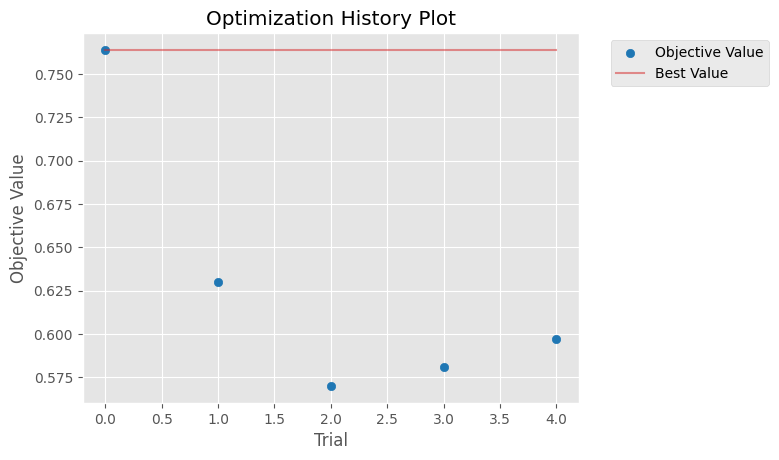

/tmp/ipykernel_16014/3851300317.py:23: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  ax2 = plot_intermediate_values(study)


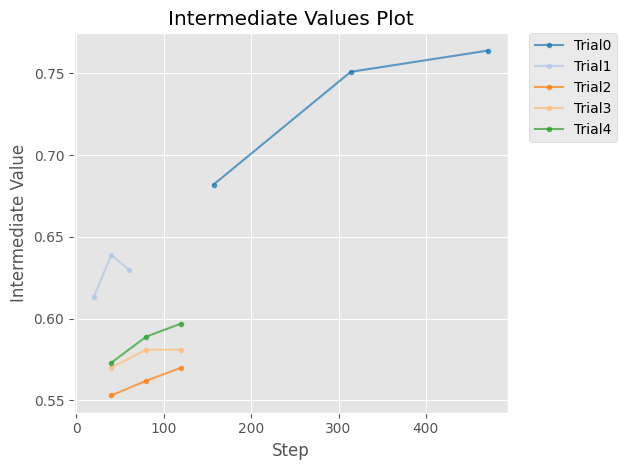

/tmp/ipykernel_16014/3851300317.py:28: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax3 = plot_param_importances(study)


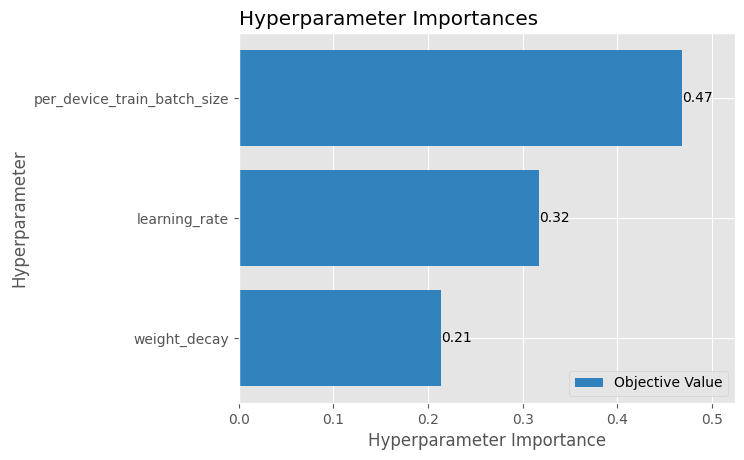

In [2]:
import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_intermediate_values,
    plot_param_importances
)
import matplotlib.pyplot as plt

# Load the study from RDB storage
storage = optuna.storages.RDBStorage("sqlite:///optuna_trials.db")

study = optuna.load_study(
    study_name="transformers_optuna_study",
    storage=storage
)

# Plot optimization history
ax1 = plot_optimization_history(study)
plt.show()
ax1.figure.savefig("optimization_history.png")

# Plot intermediate values (if using pruning and intermediate reports)
ax2 = plot_intermediate_values(study)
plt.show()
ax2.figure.savefig("intermediate_values.png")

# Plot parameter importances
ax3 = plot_param_importances(study)
plt.show()
ax3.figure.savefig("param_importances.png")


## Perform Final Training

Once you've completed hyperparameter optimization with Optuna, it’s time to capitalize on your best findings and carry out the final round of training. 

### 1. **Retrieve Your Ingredients**  
   Access the best set of hyperparameters identified during the tuning process. 

### 2. **Configure Training Parameters**  
   Plug those hyperparameter values into your training setup. This might include adjustments to learning rate, batch size, number of epochs, dropout rate, and other model-specific knobs that influence training behavior.

### 3. **Incorporate into Model Setup**  
   Apply the optimized values to initialize and configure your model. This ensures your final training run is guided by the most effective settings discovered through trial and error.

### 4. **Fine-Tune Your Training Pipeline**  
   Set up your optimizer, loss function, and data loaders using the best parameters. Everything from how fast your model learns to how much data it sees at once should reflect your refined configuration.

### 5. **Run Full Training**  
   Begin training your model using the entire training dataset (or at least the train/validation split you used during HPO). This pass should reflect your best shot at learning the patterns in the data without exploratory variation.

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load IMDb dataset
dataset = load_dataset("imdb")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Clean up columns
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Set PyTorch format
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Subset for quick testing (optional)
train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2000))
valid_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(500))


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Define the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Load best hyperparameters (already defined earlier as best_hparams)
training_args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=best_hparams["learning_rate"],
    per_device_train_batch_size=best_hparams["per_device_train_batch_size"],
    weight_decay=best_hparams["weight_decay"],    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="epoch",
    num_train_epochs=3,
    report_to="wandb",
    run_name="final_run_with_best_hparams"
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    processing_class=tokenizer,  
    compute_metrics=lambda eval_pred: {
        "accuracy": (eval_pred.predictions.argmax(-1) == eval_pred.label_ids).mean()
    }
)

# Train
trainer.train()

# Save the model
trainer.save_model("./final_model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_5615/1607841219.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.456700,0.337511,0.856000
2,0.215200,0.438220,0.876000
3,0.084600,0.499159,0.888000


## Uploading to Hugging Face Hub

You've successfully trained a powerful and optimized model, it's time to serve it up to the world. Sharing your model on the Hugging Face Hub not only makes it reusable and accessible for inference, but also contributes to the open-source community.

### 1. **Celebrate the Optimization Payoff**  
   After rigorous tuning and final training, your model now performs more efficiently and consistently. These improvements make it ideal for real-world tasks such as sentiment analysis, like classifying movie reviews to fine-tune content recommendations.

### 2. **Save Your Work Locally**  
   Before sharing, save the trained model—including the weights, configuration, tokenizer (if applicable), and training artifacts—on your local system. This step ensures that your model setup is reproducible and ready to be uploaded.

### 3. **Authenticate with Hugging Face Hub**  
   To upload your model, you’ll need to log in to the Hugging Face Hub. Whether through a terminal or notebook interface, authentication links your environment to your personal or organizational space on the platform, enabling push access.

### 4. **Upload and Share**  
   Push your saved model to the Hugging Face Hub. This makes the model publicly accessible—or private and enables others to load, use, and fine-tune it. You’ll also create a model card to explain what the model does, its intended use cases, and performance benchmarks.

#### 📌 Why It Matters:
- Centralized model storage encourages versioning, reproducibility, and transparency.
- The Hub simplifies integration for downstream tasks through `transformers`compatible APIs.
- Sharing models builds your profile and supports collaboration within the machine learning community.

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load your saved model from the path
model = AutoModelForSequenceClassification.from_pretrained("./final_model")
tokenizer = AutoTokenizer.from_pretrained("./final_model")

# Push to your repository on the hub
model.push_to_hub("AINovice2005/bert-imdb-optuna-hpo")
tokenizer.push_to_hub("AINovice2005/bert-imdb-optuna-hpo")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AINovice2005/bert-imdb-optuna-hpo/commit/cf4e9bcfd581cc9cd33f7403c5fa2e5074f58e6c', commit_message='Upload tokenizer', commit_description='', oid='cf4e9bcfd581cc9cd33f7403c5fa2e5074f58e6c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AINovice2005/bert-imdb-optuna-hpo', endpoint='https://huggingface.co', repo_type='model', repo_id='AINovice2005/bert-imdb-optuna-hpo'), pr_revision=None, pr_num=None)